In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import classifiers.classifier as classifier
import seaborn as sns
import standard_sequences.rabi_tomo as tomo
import analysis.analysis as analysis
import time
import traceback
from scipy.optimize import minimize
import joblib
from pathlib import Path
#import scipy.linregress 

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)



Qubit(ge_ssm=-0.1144, mixer_offset_ge=2.5, ge_time=77, ro_freq=6.72739, RO_IF=None, ef_time=44, ge_amp=1.01, RO_LO=6.6247, qubit_thr=[-10000, -600], ro_amp=0.25, ef_amp=1.5, IQ_angle=60, ef_half_time=25, ro_dur=5000, mixer_offset_ef=6, RO_LO_pwr=16, ROIF=0.10268999999999995, qubit_id=q1, ef_ssm=-0.25684, ef_half_amp=1.3)
Qubit(ge_ssm=-0.154, mixer_offset_ge=None, ge_time=74, ro_freq=6.65554, RO_IF=None, ef_time=None, ge_amp=0.4, RO_LO=6.6247, qubit_thr=[-10000, 1900], ro_amp=0.45, ef_amp=1, IQ_angle=25, ef_half_time=None, ro_dur=5000, mixer_offset_ef=None, RO_LO_pwr=16, ROIF=0.030840000000000423, qubit_id=q2, ef_ssm=-0.2962, ef_half_amp=None)


In [3]:
def correct_probabilities_over_time(M: np.ndarray,
                                    P_measured_mat: np.ndarray
                                   ) -> np.ndarray:
    """
    Perform constrained least-squares inversion on each column of P_measured_mat.
    
    Args:
        M:             (3×3) scale/assignment matrix.
        P_measured_mat:(3×N) measured probability columns.
    
    Returns:
        P_true_mat:   (3×N) corrected, physical probability columns.
    """
    num_levels, num_times = P_measured_mat.shape
    assert M.shape == (num_levels, num_levels), "M must be square of size 3"
    
    # Prepare output
    P_true_mat = np.zeros_like(P_measured_mat)
    
    # Common settings
    bounds = [(0, 1)] * num_levels
    constraint = {'type': 'eq', 'fun': lambda P: np.sum(P) - 1}

    # Loss function factory
    def make_loss(P_meas):
        return lambda P_true: np.linalg.norm(M @ P_true - P_meas)**2

    # Loop over each time index
    for i in range(num_times):
        P_meas = P_measured_mat[:, i]
        loss = make_loss(P_meas)
        x0 = np.ones(num_levels) / num_levels  # uniform initial guess
        
        res = minimize(loss,
                       x0,
                       bounds=bounds,
                       constraints=[constraint])
        
        if not res.success:
            raise RuntimeError(f"Optimization failed at column {i}: {res.message}")
        
        P_true_mat[:, i] = res.x
    
    return P_true_mat

In [4]:
def bayesian_unfolding(M: np.ndarray,
                       P_measured: np.ndarray,
                       iterations: int = 4
                      ) -> np.ndarray:
    """
    Perform iterative Bayesian unfolding (D’Agostini method).

    Parameters:
        M            : (3×3) assignment matrix where M[j, i] = P(measured=j | true=i)
        P_measured   : (3×N) measured probability matrix (each column sums to 1)
        iterations   : number of unfolding iterations (typically 3–5)

    Returns:
        P_true       : (3×N) unfolded (corrected) probability matrix
    """
    levels, N = P_measured.shape
    assert M.shape == (levels, levels), "M must be a square matrix matching the number of levels"

    # Initialize the prior as a uniform distribution
    P_true = np.ones((levels, N)) / levels

    for _ in range(iterations):
        # 1) Predict the measured distribution:
        #    predicted[j, n] = sum_i M[j, i] * P_true[i, n]
        predicted = M.dot(P_true)
        predicted[predicted == 0] = 1e-16  # avoid division by zero

        # 2) Compute the correction factors:
        #    ratio[j, n] = P_measured[j, n] / predicted[j, n]
        ratio = P_measured / predicted

        # 3) Update the estimate of the true distribution:
        #    P_true[i, n] *= sum_j M[j, i] * ratio[j, n]
        P_true = P_true * (M.T.dot(ratio))

        # 4) Renormalize each column to sum to 1
        P_true /= np.sum(P_true, axis=0, keepdims=True)

    return P_true

In [5]:

def run_rabi_tomo(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    tomography: str,
    state:str,
    rabi_freq: float,
    drive_amp: float,
    y_phase: float,
    x_phase: float,
    load_sequence:int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    
    # Run the experiment
    if load_sequence == 0:
        pass
    elif load_sequence == 1:
        tomo.rabi_ef_swap_tomo(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        drive_amp=drive_amp,
        tomo_comp=tomography,
        state_comp=state,
        rabi_freq=rabi_freq,
        y_phase=y_phase,
        x_phase=x_phase,
        
    )
    

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values
    
    

In [6]:
def run_and_average_rabi_tomo(
    q1, q2, general_vals_dict,
    num_steps, sweep_time, swap_freq, swap_time,
    reps, tomography, state, rabi_freq, drive_amp, y_phase, x_phase,
    runs=3,
):
    """
    Runs `run_rabi_tomo` `runs` times and returns the mean DataFrame.

    Returns:
      df_avg: pd.DataFrame indexed by 'time', with all columns averaged.
    """
    dfs = []
    for i in range(runs):
        # for the first run we allow load_sequence=1, thereafter 0
        load_sequence = 1 if i == 0 else 0

        # run one tomography
        df_prob, _, _ = run_rabi_tomo(
            q1, q2, general_vals_dict,
            num_steps, sweep_time, swap_freq, swap_time,
            reps, tomography, state,
            rabi_freq, drive_amp, y_phase, x_phase,
            load_sequence
        )

        # ensure 'time' is the index
        if "time" in df_prob.columns:
            df_prob = df_prob.set_index("time")

        dfs.append(df_prob)

    # concatenate along a new 'run' level and average over runs
    big = pd.concat(dfs, keys=range(runs), names=("run", "time"))
    df_avg = big.groupby("time").mean()

    return df_avg


In [28]:
reps=2000
sweep_time=40000#
swap_freq=-0.0194
num_steps=101
swap_time = 0.5 * 7 / abs(swap_freq)
state = "e"
tomography="z"
rabi_freq=q1.ef_ssm
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / q1.ef_amp
    # if J is in units of rad/micros
J_to_a = 1 / a_to_J
y_phase = 0
x_phase = 0
# q1.ef_half_amp=1.3
# drive_amp=1.49
# print(f"drive_amp 1.49:J={drive_amp*a_to_J}")
drive_amp =0#q1.ef_amp#0.285*J_to_a#0*J_to_a #0.285 EP#
# while True:
#     try:
#         df_prob_avg = run_and_average_rabi_tomo(
#             q1=q1,
#             q2=q2,
#             general_vals_dict=general_vals_dict,
#             num_steps=num_steps,
#             sweep_time=sweep_time,
#             swap_freq=swap_freq,
#             swap_time=swap_time,
#             reps=reps,
#             tomography=tomography,
#             state=state,
#             rabi_freq=rabi_freq,
#             drive_amp=drive_amp,
#             y_phase=y_phase,
#             x_phase=x_phase,
#             runs=2,

#         )
#         break  # Exit loop when measurements complete successfully
#     except Exception as e:
#         print("An error occurred:")
#         traceback.print_exc()
#         print("Restarting in 5 seconds...")
#         time.sleep(5)

df_prob_avg, _, _ = run_rabi_tomo(
            q1, q2, general_vals_dict,
            num_steps, sweep_time, swap_freq, swap_time,
            reps, tomography, state, rabi_freq,drive_amp,y_phase,x_phase=x_phase,load_sequence=1
        )



writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 2000
Buffers per acquistion: 66
DAQ samples per pattern: 8192
0, No error
Capturing 66 buffers. Press <enter> to abort
Capture completed in 21.341039 sec
Captured 66 buffers (3.092633 buffers per sec)
Captured 202752 records (9500.568391 records per sec)
Transferred 3321888768 bytes (155657312.513025 bytes per sec)


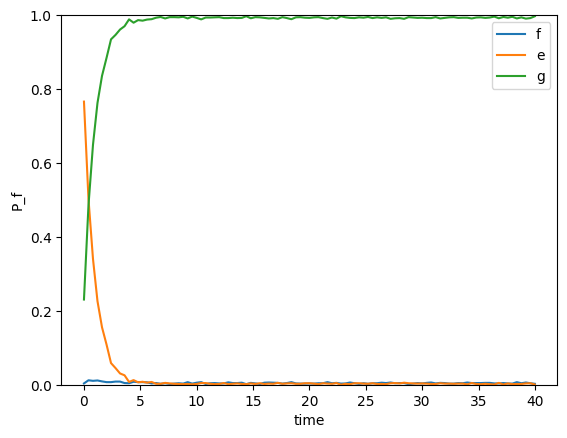

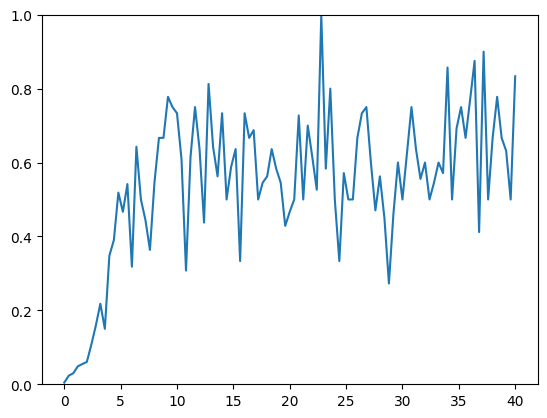

In [31]:
# df_prob_avg = pd.read_pickle('rabi_runs/dfprob_run0.pkl')
df_prob_avg = df_prob_avg.reset_index()
sns.lineplot(data=df_prob_avg, x="time", y="P_f", label="f")
sns.lineplot(data=df_prob_avg, x="time", y="P_e", label="e")
sns.lineplot(data=df_prob_avg, x="time", y="P_g", label="g")
plt.legend()
plt.ylim(0, 1)
plt.show()
normalized_Pf=df_prob_avg["P_f"]/(df_prob_avg["P_e"]+df_prob_avg["P_f"])
plt.ylim(0, 1)

plt.plot(df_prob_avg["time"], normalized_Pf, label="P_f")


C:\Users\quantum1\AppData\Local\Temp\ipykernel_13096\1922132229.py:6: RuntimeWarning: invalid value encountered in divide
  normalized_sclaed_f_plus=P_matrix_plus_scaled[2]/(P_matrix_plus_scaled[1]+P_matrix_plus_scaled[2])


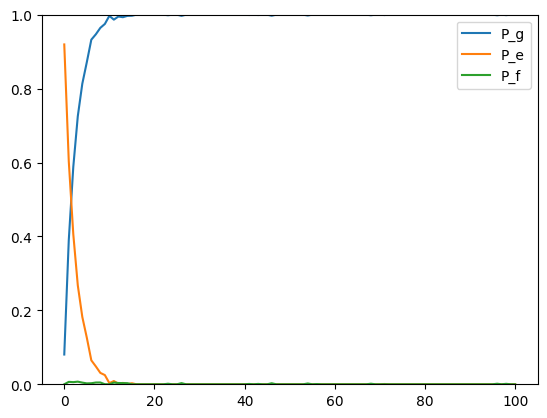

[3.03576608e-18 6.52788252e-03 5.79562625e-03 7.08789916e-03
 4.50831347e-03 2.47324388e-03 2.82622831e-03 4.72626248e-03
 4.83217118e-03 2.15586537e-04 0.00000000e+00 4.64132943e-03
 3.46222322e-03 3.14083500e-03 2.98511667e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.55111512e-17 0.00000000e+00
 5.55111512e-17 5.55111512e-17 1.66533454e-16 1.48516277e-03
 0.00000000e+00 1.66533454e-16 3.09267571e-03 1.66533454e-16
 0.00000000e+00 5.55111512e-17 5.55111512e-17 5.55111512e-17
 5.55111512e-17 0.00000000e+00 1.66533454e-16 1.66533454e-16
 5.55111512e-17 5.55111512e-17 5.55111512e-17 1.11022302e-16
 1.66533454e-16 9.00745460e-04 5.55111512e-17 9.59333340e-04
 5.55111512e-17 1.66533454e-16 2.77117312e-03 0.00000000e+00
 5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17
 1.66533454e-16 0.00000000e+00 2.12816796e-03 0.00000000e+00
 6.37830747e-04 5.55111512e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.11022302e-16 5.55111512e-17 0.00000000e+00
 0.00000000e+00 5.551115

['df_prob_scaled.pkl']

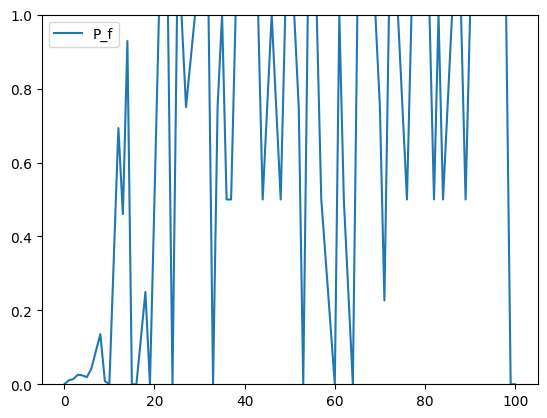

In [38]:
scale_matrix= joblib.load("classifiers/scale_matrix.pkl")
scale_matrix_inv = np.linalg.inv(scale_matrix)
P_matrix_plus=np.array([df_prob_avg["P_g"], df_prob_avg["P_e"], df_prob_avg["P_f"]])
P_matrix_plus_scaled =correct_probabilities_over_time(scale_matrix, P_matrix_plus)#bayesian_unfolding(scale_matrix, P_matrix_plus,5)####b##bayesian_unfolding(scale_matrix, P_matrix_plus,14)###########correct_probabilities_over_time(scale_matrix, P_matrix_plus)#bayesian_unfolding(scale_matrix, P_matrix_plus,4)#scale_matrix_inv@P_matrix_plus#bayesian_unfolding(scale_matrix, P_matrix_plus,11)##@##correct_probabilities_over_time(scale_matrix, P_matrix_plus)#bayesian_unfolding(scale_matrix, P_matrix_plus,7)

normalized_sclaed_f_plus=P_matrix_plus_scaled[2]/(P_matrix_plus_scaled[1]+P_matrix_plus_scaled[2])
plt.plot(P_matrix_plus_scaled[0], label="P_g")
plt.plot(P_matrix_plus_scaled[1], label="P_e")
plt.plot(P_matrix_plus_scaled[2], label="P_f") 
plt.ylim(0, 1)
plt.legend()

plt.show()
sns.lineplot(data=normalized_sclaed_f_plus, label="P_f")
plt.ylim(0, 1)
print(P_matrix_plus_scaled[2])
df_prob_scaled = pd.DataFrame(
        {
            "time": df_prob_avg["time"],
            "P_f": P_matrix_plus_scaled[2],
            "P_e": P_matrix_plus_scaled[1],
            "P_g": P_matrix_plus_scaled[0],
        },
        
    )
joblib.dump(df_prob_scaled, "df_prob_scaled.pkl")

In [10]:
# normalized_Pf=df_prob_plus["P_f"]/(df_prob_plus["P_e"]+df_prob_plus["P_f"])
# plt.plot(df_prob_plus["time"], normalized_Pf, label="P_f")

In [11]:
# P_matrix_minus=np.array([df_prob_minus["P_g"], df_prob_minus["P_e"], df_prob_minus["P_f"]])
# P_matrix_minus_scaled =inv_scale_matrix_calibrated@P_matrix_minus
# normalized_sclaed_f_minus=P_matrix_minus_scaled[2]/(P_matrix_minus_scaled[1]+P_matrix_minus_scaled[2])
# normalized_sclaed_e_minus=P_matrix_minus_scaled[1]/(P_matrix_minus_scaled[1]+P_matrix_minus_scaled[2])
# plt.plot(P_matrix_minus_scaled[0], label="P_g")
# plt.plot(P_matrix_minus_scaled[1], label="P_e")
# plt.plot(P_matrix_minus_scaled[2], label="P_f") 
# plt.legend()
# plt.ylim(0, 1)
# plt.show()

In [12]:
# plt.plot(normalized_sclaed_f_plus, label="z+")
# # plt.plot(normalized_sclaed_e_minus, label="z-")
# plt.title("state x")
# plt.ylabel("normalized scaled f")
# plt.xlabel("time (us)")
# plt.legend()
# plt.ylim(0, 1)

In [13]:
# normalized_f_plus=df_prob_plus["P_f"]/(df_prob_plus["P_f"]+df_prob_plus["P_e"])
# normalized_e_plus=df_prob_plus["P_e"]/(df_prob_plus["P_f"]+df_prob_plus["P_e"])
# normalized_f_minus=df_prob_minus["P_f"]/(df_prob_minus["P_f"]+df_prob_minus["P_e"])
# normalized_e_minus=df_prob_minus["P_e"]/(df_prob_minus["P_f"]+df_prob_minus["P_e"])

# plt.plot(df_prob_plus["time"],normalized_f_plus,label="f+")
# plt.plot(df_prob_plus["time"],normalized_e_plus,label="e+")
# # plt.ylim(0,1)
# plt.show()

# plt.plot(df_prob_minus["time"],normalized_f_minus,label="f-")
# plt.plot(df_prob_minus["time"],normalized_e_minus,label="e-")
# plt.ylim(0,1)
# plt.show()

# # plt.plot(df_prob_plus["time"],normalized_f_plus*0.7+normalized_e_minus*0.3,label="f+")
# # plt.ylim(0, 1)
# # plt.plot(df_prob_plus["time"],normalized_e_plus,label="e+")
# plt.show()
# plt.plot(df_prob_plus["time"],df_prob_plus["P_g"]-df_prob_minus["P_g"])
# # plt.ylim(0, 1)
# # plt.plot(df_prob_plus["time"],normalized_e_plus,label="e+")
# plt.show()

In [14]:
# scale_matrix=np.array([[9.88593333e-01, 1.71256667e-01, 1.00090000e-01],
#  [5.08333333e-04, 8.15883333e-01, 3.44100000e-02],
#  [1.08983333e-02 ,1.28600000e-02 ,8.65500000e-01]])
# inv_scale_matrix=np.linalg.inv(scale_matrix)
# P_matrix_plus=np.array([df_prob_plus["P_g"], df_prob_plus["P_e"], df_prob_plus["P_f"]])
# P_matrix_minus=np.array([df_prob_minus["P_g"], df_prob_minus["P_e"], df_prob_minus["P_f"]])
# P_matrix_plus_scaled =inv_scale_matrix@P_matrix_plus#smooth_inversion(scale_matrix, P_matrix_plus, lam=1e-6)#correct_probabilities_over_time(scale_matrix, P_matrix_plus)#inv_scale_matrix@P_matrix_plus#correct_probabilities_over_time(scale_matrix, P_matrix_plus)#bayesian_unfolding(scale_matrix, P_matrix_plus, iterations=10) #inv_scale_matrix@P_matrix_plus #bayesian_unfolding(scale_matrix, P_matrix_plus, iterations=100) #correct_probabilities_over_time(scale_matrix, P_matrix_plus)
# P_matrix_minus_scaled = inv_scale_matrix@P_matrix_minus#bayesian_unfolding(scale_matrix, P_matrix_minus, iterations=10)#inv_scale_matrix@P_matrix_minus#bayesian_unfolding(scale_matrix, P_matrix_minus, iterations=100) #correct_probabilities_over_time(scale_matrix, P_matrix_minus)
# normalized_sclaed_f_plus=P_matrix_plus_scaled[2]/(P_matrix_plus_scaled[1]+P_matrix_plus_scaled[2])
# normalized_sclaed_e_plus=P_matrix_plus_scaled[1]/(P_matrix_plus_scaled[1]+P_matrix_plus_scaled[2])
# P_f_average=(P_matrix_plus_scaled[2]+P_matrix_minus_scaled[1])/2
# P_e_average=(P_matrix_plus_scaled[1]+P_matrix_minus_scaled[2])/2
# P_f_average_norm=P_f_average/(P_f_average+P_e_average)
# normalized_sclaed_f_minus=P_matrix_minus_scaled[2]/(P_matrix_minus_scaled[1]+P_matrix_minus_scaled[2])
# normalized_sclaed_e_minus=P_matrix_minus_scaled[1]/(P_matrix_minus_scaled[1]+P_matrix_minus_scaled[2])
# plt.plot(P_matrix_plus_scaled[0], label="P_g")
# plt.plot(P_matrix_plus_scaled[1], label="P_e")
# plt.plot(P_matrix_plus_scaled[2], label="P_f") 
# plt.legend()
# plt.ylim(0, 1)
# plt.show()
# plt.plot(P_matrix_minus_scaled[0], label="P_g")
# plt.plot(P_matrix_minus_scaled[1], label="P_e")
# plt.plot(P_matrix_minus_scaled[2], label="P_f") 
# plt.legend()
# plt.ylim(0, 1)
# plt.show()
# sns.lineplot(data=normalized_sclaed_f_plus, label="P_f")
# sns.lineplot(data=normalized_sclaed_e_minus, label="P_e add pi pulse")
# plt.ylim(0, 1)
# plt.show()
# plt.plot(df_prob_plus["time"],normalized_sclaed_f_plus*0.5+normalized_sclaed_e_minus*0.5, label="f")
# plt.ylim(0, 1)
# plt.show()



In [15]:
# P_matrix_plus_scaled[1][40]
# # inv_scale_matrix@np.array([1, 0.0008, 0.0142])
# # df_prob_plus["P_e"][40]

In [16]:
# average_f=(P_matrix_plus[2]+P_matrix_plus[1])/2
# average_e=(P_matrix_minus[2]+P_matrix_minus[1])/2
# normf=average_f/(average_f+average_e)
# plt.plot(df_prob_plus["time"],normf,label="f")

In [17]:
# Loop over each state and plot separately
# for state in ["e", "f", "x"]:
#     # 1) load & build
#     df_tomo = load_and_build_df_tomo(state)

#     # 2) turn index into a time column
#     df_plot = df_tomo.reset_index().rename(columns={'index':'time'})

#     # 3) plot z, x, y P_f curves
#     plt.figure(figsize=(6, 4))
#     sns.lineplot(data=df_plot, x="time", y="P_f_tomo_z", label="z")
#     sns.lineplot(data=df_plot, x="time", y="P_f_tomo_x", label="x")
#     sns.lineplot(data=df_plot, x="time", y="P_f_tomo_y", label="y")
#     plt.title(f"{state} full tomography (P_f)")
#     plt.xlabel("time")
#     plt.ylim(0, 1)
#     plt.legend(title="axis")
#     plt.show()

In [18]:
# reps = 5000
# sweep_time = 80
# swap_freq = -0.0194
# swap_time =   0.5 * 7 / abs(swap_freq)
# J = 10
# num_steps = 51
# tomography = "z"
# df_prob, df_pop, values = run_rabi_tomo(
#     q1=q1,
#     q2=q2,
#     general_vals_dict=general_vals_dict,
#     num_steps=num_steps,
#     sweep_time=sweep_time,
#     swap_freq=swap_freq,
#     swap_time=swap_time,
#     reps=reps,
#     tomography=tomography,
#     state="e",
# )


In [19]:
# plt.figure(dpi=150)
# sns.lineplot(data=df_prob, x="time", y="P_f", label="f")
# sns.lineplot(data=df_prob, x="time", y="P_e", label="e")
# sns.lineplot(data=df_prob, x="time", y="P_g", label="g")
# plt.title(f"{tomography} tomography")
# plt.legend()
# plt.ylim(0, 1)
# plt.show()
# plt.figure(dpi=150)
# normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
# normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])
# sns.lineplot(data=normalized_f, label="f")
# # sns.lineplot(data=normalized_e, label="e")
# plt.title(f"Normalized f and e populations, Tomo = {tomography}")

# plt.ylim(0, 1)
# plt.legend()
# plt.show()

In [20]:
# def run_rabi_tomo_phase(
#     q1,
#     q2,
#     general_vals_dict,
#     num_steps: int,
#     sweep_time: float,
#     swap_freq: float,
#     swap_time: float,
#     reps: int,
#     tomography: str,
#     phase_start:float,
#     phase_stop:float,

# ):
#     """
#     Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
#     and processes the resulting IQ data to compute probabilities vs. time.

#     Returns:
#         df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
#                                 np.linspace(0, sweep_time/1000, num_steps)) and which has
#                                 columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
#                                 of the f, e, and g states respectively.
#     """
#     # Run the experiment
#     tomo.rabi_tomo_phase(
#         q1,
#         q2,
#         general_vals_dict,
#         num_steps=num_steps,
#         sweep_time=sweep_time,
#         swap_freq=swap_freq,
#         swap_time=swap_time,
#         drive_amp_J=0,
#         tomo_comp=tomography,
#         phase_start=phase_start,
#         phase_stop=phase_stop

    
#     )

#     wx.wx_set_and_amplitude_and_offset(
#         amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
#     )
#     # Acquire the raw IQ data
#     values = daq.run_daq_het_2q(
#         q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
#     )

#     # Retrieve raw IQ data from the acquired values
#     I1_raw = values.rec_readout_1[0]
#     Q1_raw = values.rec_readout_1[1]
#     I2_raw = values.rec_readout_2[0]
#     Q2_raw = values.rec_readout_2[1]

#     # Build a DataFrame from the IQ data for classification
#     IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

#     # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
#     classified = classifier.classify(IQ_df)
#     states = classified["predicted"]
#     # Reshape the predicted states.
#     # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
#     #  where each row corresponds to a time step and holds all the state measurements for that step.)
#     states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
#     probabilties = classifier.probabilities(states_reshaped)
#     population = classifier.population(states_reshaped)

#     # Compute time values as the index for the DataFrame.
#     times = np.linspace(phase_start,phase_stop, num_steps)

#     # Build a DataFrame that holds the probability vs. time.
#     df_prob = pd.DataFrame(
#         {
#             "time": times,
#             "P_f": probabilties["P_f"],
#             "P_e": probabilties["P_e"],
#             "P_g": probabilties["P_g"],
#         },
#         index=times,
#     )

#     df_pop = pd.DataFrame(
#         {
#             "time": times,
#             "Pop_f": population["Pop_f"],
#             "Pop_e": population["Pop_e"],
#             "Pop_g": population["Pop_g"],
#         },
#         index=times,
#     )

#     return df_prob, df_pop, values

In [21]:
# def sweep_amp_tomo_x(amp_list:list):
#     reps = 50000
#     sweep_time = 250
#     swap_freq = -0.0194
#     swap_time =   0.5 * 7 / abs(swap_freq)
#     J = 10
#     num_steps = 3
#     tomography = "y"
#     scale_matrix_inv = np.array([
#     [-0.00972053 , 1.00972053],
#     [ 1.00972053 ,-0.00972053]
#     ])
#     P_f = np.zeros(len(amp_list))
#     for i,amp in enumerate(amp_list):
#         q1.ef_half_amp_y =amp

#         # q1.ef_amp=0.05
#         # q1.ef_ssm=-0.2568
#         df_prob, df_pop, values = run_rabi_tomo(
#             q1=q1,
#             q2=q2,
#             general_vals_dict=general_vals_dict,
#             num_steps=num_steps,
#             sweep_time=sweep_time,
#             swap_freq=swap_freq,
#             swap_time=swap_time,
#             reps=reps,
#             tomography=tomography,
#         )
#         normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
#         normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])
#         P_matrix = np.array([normalized_f[0],normalized_e[0]])
#         P_f[i]=np.matmul(scale_matrix_inv,P_matrix)[1]
#     return P_f
        


In [22]:
# amp_start=1.3
# amp_stop=1.4
# amp_steps= 11
# amp_list = np.linspace(amp_start,amp_stop,amp_steps)
# P_f=sweep_amp_tomo_x(amp_list)

In [23]:
# plt.figure(dpi=150)
# plt.plot(amp_list, P_f)

# plt.xlabel("ef_half_amp_x")
# plt.ylabel("P_f")
# plt.axhline(0.5, color="black", linestyle="--")
# plt.axvline(1.354, color="black", linestyle="--")
# plt.legend()
# plt.show()


In [24]:
# # Define the list of y_ph values to sweep over
# x_ph_list = np.linspace(165,195, 41)  # Example list, replace with your actual values

# reps = 2000
# sweep_time = 1
# swap_freq = -0.0195
# swap_time = 0.5 * 6 / abs(swap_freq)
# J = 35
# num_steps =1
# tomography = "z"
# y_ph = 77
# # Define the folder to save results
# save_folder = "x_ph_sweep"
# os.makedirs(save_folder, exist_ok=True)

# # Define a checkpoint file to track progress
# checkpoint_file = os.path.join(save_folder, "checkpoint.txt")

# # Load the last completed y_ph value if the checkpoint file exists
# if os.path.exists(checkpoint_file):
#     with open(checkpoint_file, "r") as f:
#         last_completed_x_ph = float(f.read().strip())
# else:
#     last_completed_x_ph = None

# # Loop over the y_ph values
# for x_ph in x_ph_list:
#     # Skip already completed y_ph values
#     if last_completed_x_ph is not None and x_ph <= last_completed_x_ph:
#         print(f"Skipping x_ph = {x_ph} (already completed)")
#         continue

#     print(f"Running for x_ph = {x_ph}")

#     # Run the Rabi tomography simulation
#     df_prob, df_pop, values = run_rabi_tomo(
#         q1=q1,
#         q2=q2,
#         general_vals_dict=general_vals_dict,
#         num_steps=num_steps,
#         sweep_time=sweep_time,
#         swap_freq=swap_freq,
#         swap_time=swap_time,
#         reps=reps,
#         tomography=tomography,
#         J=J,
#         y_ph=y_ph,
#         x_tomo_ph= x_ph
#     )

#     # Save the df_prob dataframe
#     save_filename = os.path.join(save_folder, f"df_prob_x_ph_{x_ph}.csv")
#     df_prob.to_csv(save_filename, index=False)
#     print(f"Saved results for x_ph = {x_ph} to {save_filename}")

#     # Update the checkpoint file
#     with open(checkpoint_file, "w") as f:
#         f.write(str(x_ph))
#     print(f"Updated checkpoint to x_ph = {x_ph}")

# print("Sweep complete!")

In [25]:
# import glob
# # Folder where your CSV files are saved
# save_folder = "x_ph_sweep"

# # Use glob to get all CSV files matching the pattern
# csv_files = glob.glob(os.path.join(save_folder, "df_prob_x_ph_*.csv"))

# x_ph_values = []
# norm_pf_values = []

# # Loop over each CSV file
# for file in csv_files:
#     # Extract the x_ph value from the filename.
#     # Assuming the filename format is: "df_prob_x_ph_{x_ph}.csv"
#     basename = os.path.basename(file)
#     # Remove the prefix and suffix to get the numeric part
#     # E.g., from "df_prob_x_ph_180.0.csv" extract "180.0"
#     x_ph_str = basename.replace("df_prob_x_ph_", "").replace(".csv", "")
#     x_ph_val = float(x_ph_str)
    
#     # Load the CSV file into a DataFrame
#     df_prob = pd.read_csv(file)
    
#     # Calculate the normalized P_f = P_f / (P_f + P_e)
#     # Assuming there's one row in the DataFrame
#     P_f = df_prob["P_f"].iloc[0]
#     P_e = df_prob["P_e"].iloc[0]
#     norm_pf = P_f / (P_f + P_e)
    
#     # Store the values
#     x_ph_values.append(x_ph_val)
#     norm_pf_values.append(norm_pf)

# # Sort the data by x_ph values (important for plotting a smooth curve)
# sorted_indices = sorted(range(len(x_ph_values)), key=lambda i: x_ph_values[i])
# x_ph_sorted = [x_ph_values[i] for i in sorted_indices]
# norm_pf_sorted = [norm_pf_values[i] for i in sorted_indices]

# # Plot normalized P_f versus x_ph
# plt.figure(figsize=(8, 6))
# plt.plot(x_ph_sorted, norm_pf_sorted, 'o-', label="Normalized $P_f$")
# plt.xlabel("$x_{ph}$")
# plt.ylabel("Normalized $P_f$")
# plt.title("Normalized $P_f$ vs. $x_{ph}$")
# plt.legend()
# plt.grid(True)
# plt.show()

In [26]:
# from scipy.optimize import curve_fit
# import analysis.fit_functions as fit_funcs  # This package should contain sine_decay

# # Extract the time values from df_prob
# time = df_prob["time"].values

# # Compute normalized populations: P_f_norm and P_e_norm
# normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
# normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])

# # Define an initial guess for the sine_decay parameters:
# # Parameters: freq_Hz, gamma, amplitude, phase_deg, offset
# initial_guess_e = [1.0, 0.1, 0.5, 0.0, 0.1]
# initial_guess_f = [1.0, 0.1, 0.5, 180, 0.1]

# # Perform curve fit for normalized f data
# popt_f, pcov_f = curve_fit(fit_funcs.sine_decay, time, normalized_f.values, p0=initial_guess_f)
# # Compute the fitted curve for normalized f
# fitted_f = fit_funcs.sine_decay(time, *popt_f)

# # Perform curve fit for normalized e data
# popt_e, pcov_e = curve_fit(fit_funcs.sine_decay, time, normalized_e.values, p0=initial_guess_e)
# # Compute the fitted curve for normalized e
# fitted_e = fit_funcs.sine_decay(time, *popt_e)

# # Plot the data and the fitted curves
# plt.figure(dpi=150)
# sns.lineplot(x=time, y=normalized_f, label="Normalized f (data)")
# sns.lineplot(x=time, y=fitted_f, label="Normalized f (fit)", linestyle="--")
# sns.lineplot(x=time, y=normalized_e, label="Normalized e (data)")
# sns.lineplot(x=time, y=fitted_e, label="Normalized e (fit)", linestyle="--")
# plt.xlabel("Time")
# plt.ylabel("Normalized Population")
# plt.title(f"Normalized f and e populations, Tomo = {tomography}")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Optionally, print the fitted parameters
# print("Fitted parameters for normalized f:")
# print(" freq_Hz =", popt_f[0])
# print(" gamma   =", popt_f[1])
# print(" amplitude =", popt_f[2])
# print(" phase_deg =", popt_f[3])
# print(" offset  =", popt_f[4])
# print("\nFitted parameters for normalized e:")
# print(" freq_Hz =", popt_e[0])
# print(" gamma   =", popt_e[1])
# print(" amplitude =", popt_e[2])
# print(" phase_deg =", popt_e[3])
# print(" offset  =", popt_e[4])